# 1. Setup

In [1]:
from time import time

import plotly.express as px
from pqdm.processes import pqdm
from scipy.optimize import curve_fit
from lightgbm import LGBMRegressor
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, BayesianRidge
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error, make_scorer)
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor

from utils import *

# 2. Prepare data

## 2.1. Load data

In [2]:
trips = pd.read_parquet(DATA / 'impedance/trips.parquet').disp()

747,088 rows x 21 cols; Memory: 34.9 MiB


,Distance,Time,Speed,Weight,Purpose,Mode,Weekend,GasPrice,StayTime,StartTime,...,Region,Age,Sex,Race,Hispanic,Education,Worker,Income,HomeOwn,VehOwn
,<float64>,<float64>,<float64>,<float64>,<category>,<category>,<category>,<category>,<category>,<category>,...,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>
0,8.439379,16.182075,31.291583,1.0,HBO,Drive,No,Low,Long,Off-peak,...,South,Senior,Female,Non-White,No,College,No,Mid,Own,High


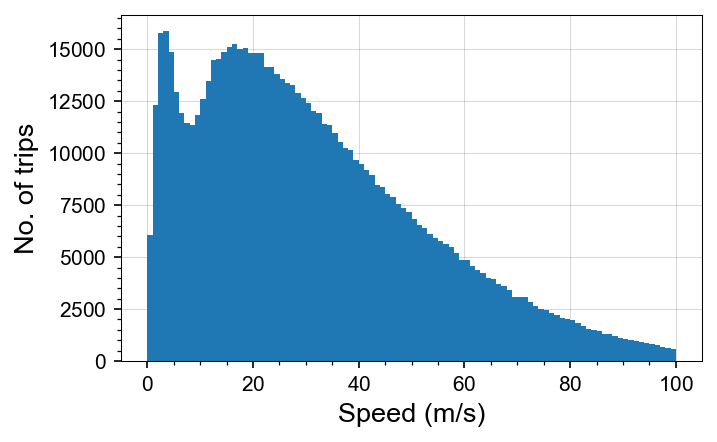

In [3]:
ax = pplot(size=(5, 3), xlab='Speed (m/s)', ylab='No. of trips')
trips.Speed.hist(bins=100, ax=ax);

In [3]:
factors = list(trips.select_dtypes(CAT).columns)

In [4]:
col_groups = []
for grp, start, end, color in [
        ('Trip', 'Purpose', 'Urbanity', 'deepskyblue'),
        ('Traveler', 'Region', 'VehOwn', 'hotpink')]:
    df = Pdf(D(factor=trips.loc[:, start: end].columns))
    col_groups.append(df.assign(group=grp, color=color))
col_groups = pd.concat(col_groups).reset_index(drop=1).disp()

17 rows x 3 cols; Memory: 0.0 MiB


,factor,group,color
,<object>,<object>,<object>
0,Purpose,Trip,deepskyblue


In [5]:
levels = Pdf(sum([[(col, x, i+1) for i, x in enumerate(trips[col].cat.categories)]
                  for col in trips.select_dtypes(CAT)], []),
             columns=['factor', 'level', 'level_num']).disp()

52 rows x 3 cols; Memory: 0.0 MiB


,factor,level,level_num
,<object>,<object>,<int64>
0,Purpose,HBW,1


# 3. Distributions

## 3.1. Interactive distributions

In [6]:
def plot_distr_vars(data=trips, width=1600, height=500):
    res = []
    for target, vmin, vmax in [('Time', 0, 90),
                               ('Distance', 0, 100),
                               ('Speed', 0, 80)]:
        for var in data.select_dtypes(CAT):
            for cat, df in data.groupby(var):
                vals = df[target].clip(vmin, vmax)
                y, x = np.histogram(vals, bins=100, weights=df.Weight)
                y = (y / y.sum()).cumsum()
                res.append(Pdf(D(value=x[1:], density=y))
                           .assign(var=var, cat=cat, target=target))
    res = pd.concat(res).reset_index(drop=1)
    fig = px.line(res, x='value', y='density', color='var', facet_col='target',
                  width=width, height=height, hover_name='cat', hover_data=['cat'],
                  labels=D(density='Cumulative probability density', var='Factor'))
    fig.update_layout(hoverlabel=D(bgcolor='white', font_size=16),
                      font=D(family='Arial', size=18))
    fig.for_each_xaxis(lambda x: x.update(matches=None))
    fig.show()

# plot_distr_vars() # 5s

## 3.2. Variable-wise histogram

In [7]:
def get_var_hist(data=trips, max_vals=D(Distance=100, Time=120)):
    res = []
    for col in data.select_dtypes(CAT).columns:
        for var, df in data.groupby(col):
            for target, vmax in max_vals.items():
                y = df[target].clip(0, vmax)
                y, x = np.histogram(y, bins=np.arange(0, vmax + 1))
                y = (1 - (y / y.sum()).cumsum()).clip(0)
                res.append(D(target=target, factor=col,
                             level=var, x=x[1:], y=y))
    res = Pdf(res)
    return res

var_hist = get_var_hist().disp() # 2s

104 rows x 5 cols; Memory: 0.1 MiB


,target,factor,level,x,y
,<object>,<object>,<object>,<object>,<object>
0,Distance,Purpose,HBW,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.9612716872850274, 0.9134028846702013, 0.863..."


# 4. Decay rate parameter

## 4.1. Select functional form

In [8]:
imped_funcs = {
    'Power': lambda x, a: x ** a,
    'Base exponential': lambda x, a: np.exp(a * x),
    'Sherratt Tanner': lambda x, a: np.exp(-a * (x ** 2)),
    'Logistic': lambda x, a: 2 * (1 + np.exp(a * x)) ** (-1),
    'Power exponential': lambda x, a, b: np.exp(-a * (x ** b)),
    'Tanner': lambda x, a, b: (x ** a) * np.exp(b * x),
    'Quadratic exponential': lambda x, a, b: np.exp(a * x - b * (x ** 2)),
    # 'Cubic exponential': lambda x, a, b, c: np.exp(-a * x + b * (x ** 2) - c * (x ** 3)),
}

In [9]:
def fit_decay_functions(funcs=imped_funcs, hists=var_hist):
    res = []
    for _, r in hists.iterrows():
        for fname, func in funcs.items():
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    params = curve_fit(func, r.x, r.y)[0]
                yfit = func(r.x, *params).clip(0, 1)
                r2 = r2_score(r.y, yfit)
                if r2 < 0 or r2 > 1: continue
            except RuntimeError as e:
                print('ERROR:', fname, r, e)
                continue
            res.append(D(target=r.target, factor=r.factor, 
                         level=r.level, func=fname,
                         r2=r2, params=list(params)))
    res = Pdf(res)
    return res

fitted = fit_decay_functions().disp()
# x = fit_decay_functions(); x

727 rows x 6 cols; Memory: 0.2 MiB


,target,factor,level,func,r2,params
,<object>,<object>,<object>,<object>,<float64>,<object>
0,Distance,Purpose,HBW,Power,0.707913,[-0.4892477188849867]


### 4.1.1. Fitness scores

In [10]:
(fitted.groupby(['func', 'target'])['r2'].describe()
 .reset_index().melt(['func', 'target'])
 .assign(statistic=lambda df: pd.Categorical(
     df.variable, categories=['mean', 'std', 'min', 'max']))
 .pivot_table('value', 'func', ['target', 'statistic'])
 .loc[list(imped_funcs.keys())].reset_index())

target                      func  Distance                                \
statistic                             mean       std       min       max   
0                          Power  0.843897  0.058662  0.612593  0.939323   
1               Base exponential  0.973893  0.011054  0.947491  0.999716   
2                Sherratt Tanner  0.790617  0.051276  0.709990  0.949013   
3                       Logistic  0.938804  0.022698  0.898645  0.996552   
4              Power exponential  0.997034  0.002333  0.987333  0.999830   
5                         Tanner  0.996027  0.003893  0.973517  0.999789   
6          Quadratic exponential  0.988310  0.007040  0.962058  0.999937   

target         Time                                
statistic      mean       std       min       max  
0          0.648618  0.039521  0.476779  0.726955  
1          0.979040  0.011420  0.927372  0.997833  
2          0.965636  0.012718  0.903767  0.991164  
3          0.991289  0.005331  0.966542  0.995715  
4          0.995530  0.001185  0.992032  0.998709  
5          0.997329  0.000980  0.993238  0.998980  
6          0.992001  0.001801  0.987652  0.997928

## 4.2. Fit curves

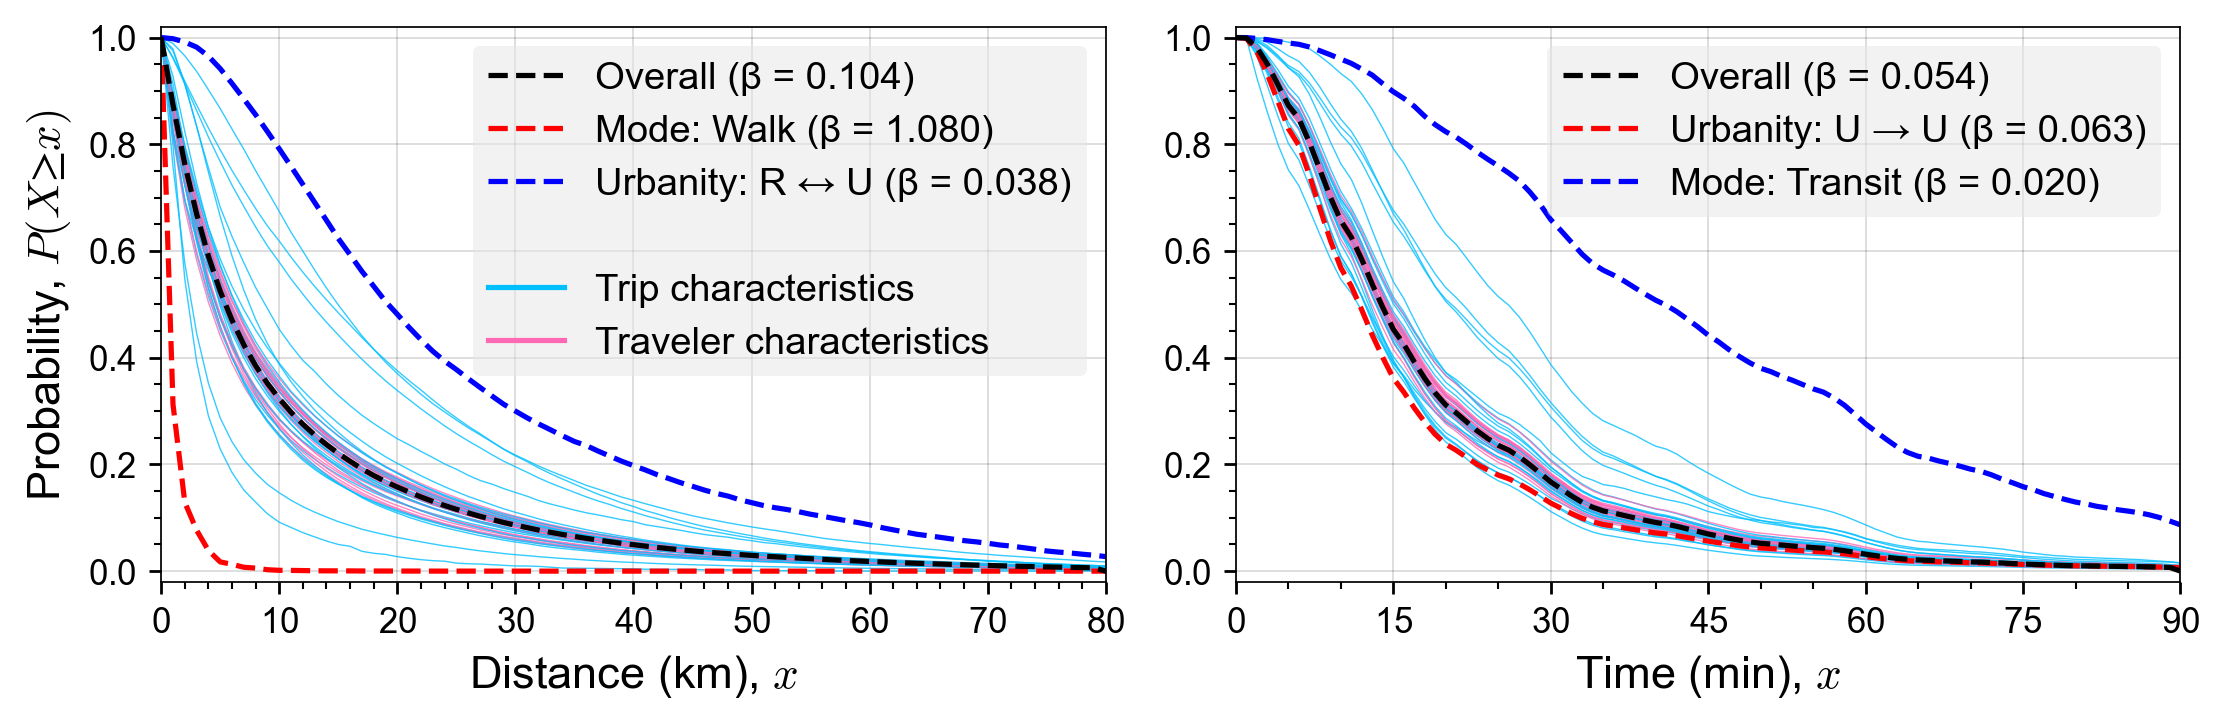

In [11]:
def fig_fitted_curves(fitted=fitted, hists=var_hist, groups=col_groups,
                      adv=True, trips=trips, size=(9, 3), dpi=150):
    fit = (fitted.query('func=="Base exponential"')
           .explode('params').rename(columns=D(params='beta'))
           .merge(groups[['factor', 'color']]))
    if not adv: fit.color = fit.color.iloc[0]
    line = lambda label, **kw: mpl.lines.Line2D([0], [0], label=label, **kw)
    _, axes = plt.subplots(1, 2, figsize=size, dpi=dpi)
    for j, target, vmax, xlab in [(0, 'Distance', 80, 'Distance (km)'),
                                  (1, 'Time', 90, 'Time (min)')]:
        Y, X = np.histogram(trips[target].clip(0, vmax), bins=np.arange(0, vmax + 1))
        Y = (1 - (Y / Y.sum()).cumsum()).clip(0)
        beta = -curve_fit(lambda x, b: np.exp(b * x), X[1:], Y)[0][0]
        lgd = [line('Overall' + (f' (β = {beta:.3f})' if adv else ''), color='k', ls='--')]
        ax = pplot(axes[j], xlim=(0, vmax), ylim=(-0.02, 1.02), xlab=f'{xlab}, $x$',
                   ylab='Probability, $P(X≥x)$' if j == 0 else '')
        df = hists.query(f'target=="{target}"')
        df = df.merge(fit[['target', 'factor', 'level', 'beta', 'color']])
        df = df.sort_values('beta').reset_index(drop=1)
        for _, r in df.iloc[1:-1].iterrows():
            ax.plot([0] + list(r.x), [1] + list(r.y), color=r.color, lw=0.4, alpha=0.8)
        for r, color in zip([df.iloc[0], df.iloc[-1]], ['r', 'b']):
            label = f'{r.factor}: {r.level}' + (f' (β = {-r.beta:.3f})' if adv else '')
            lgd += [line(label, color=color, ls='--')]
            ax.plot([0] + list(r.x), [1] + list(r.y), color=color, lw=1.5, ls='--')
        ax.plot(X, [1] + list(Y), '--k', lw=1.5)
        if target == 'Time':
            ax.set_xticks(np.arange(0, 91, 15))
            ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
        if j == 0 and adv:
            lgd += [line('', color='none')]
            for _, r in groups.drop_duplicates(subset=['group']).iterrows():
                lgd += [line(r.group + ' characteristics', color=r.color)]
        ax.legend(handles=lgd)
    plt.subplots_adjust(wspace=0.1)
    plt.tight_layout()
    imsave(f'Impedance curves by variable' + (' (no label)' if adv else ''))

fig_fitted_curves(dpi=250)

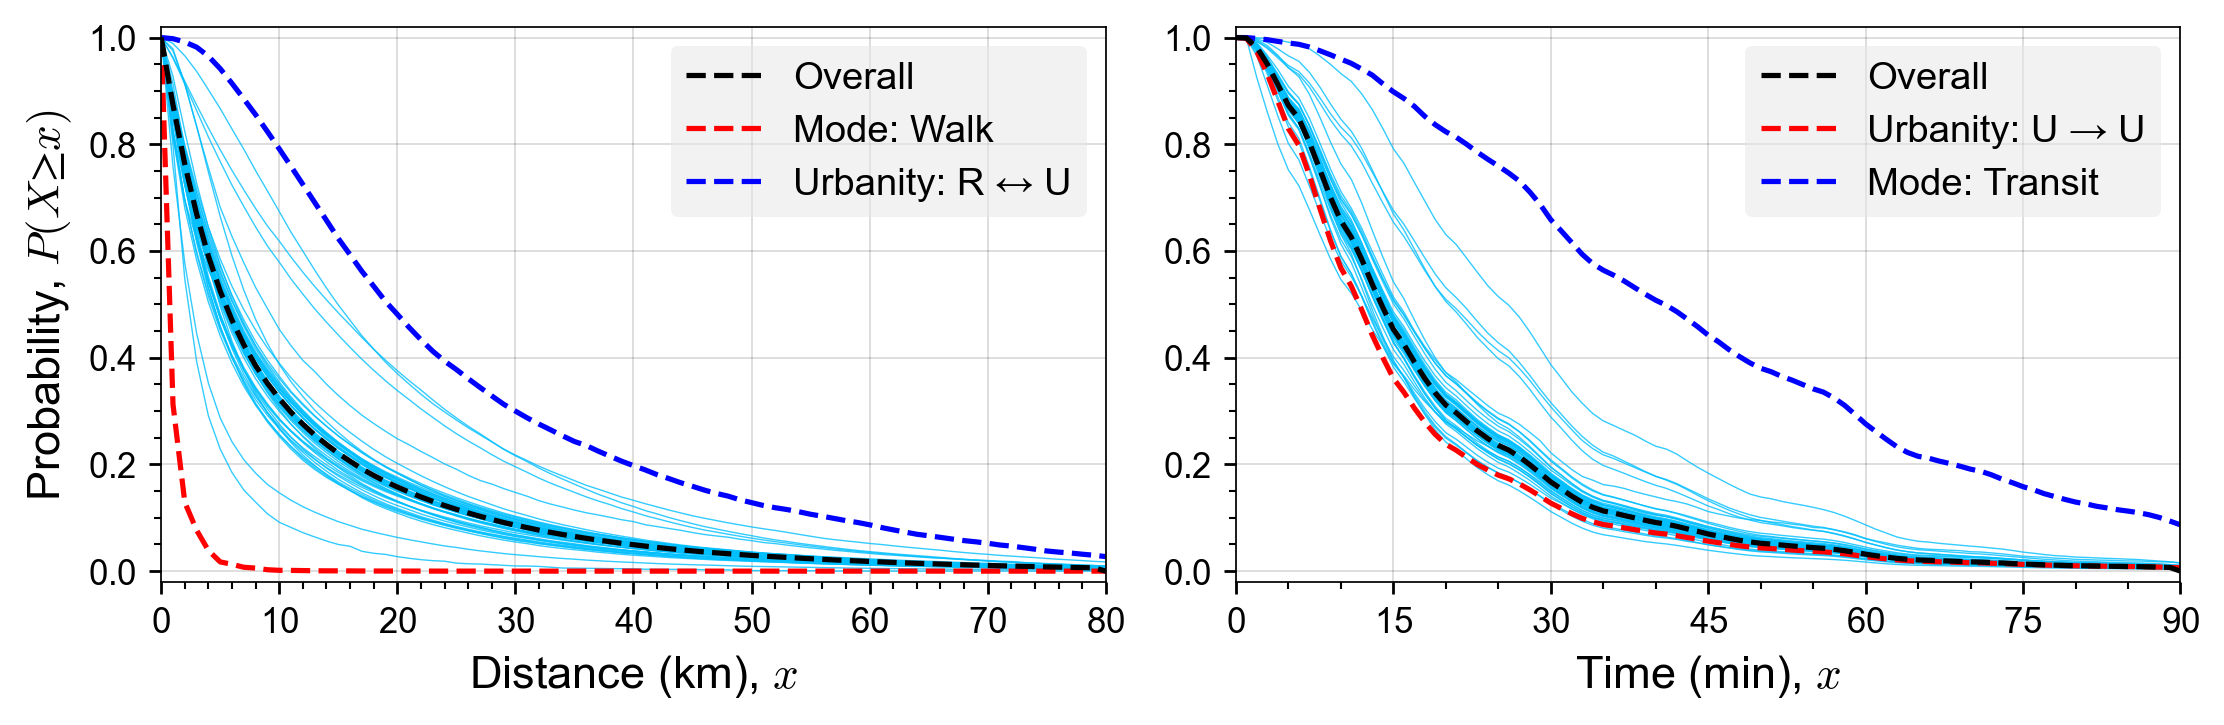

In [12]:
fig_fitted_curves(adv=False, dpi=250)

## 4.3. Compare beta parameters

104 rows x 8 cols; Memory: 0.1 MiB


,target,factor,level,x,y,group,color,beta
,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>
0,Distance,Mode,Walk,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.31236868338317614, 0.12887048539222457, 0.0...",Trip,deepskyblue,-1.079607


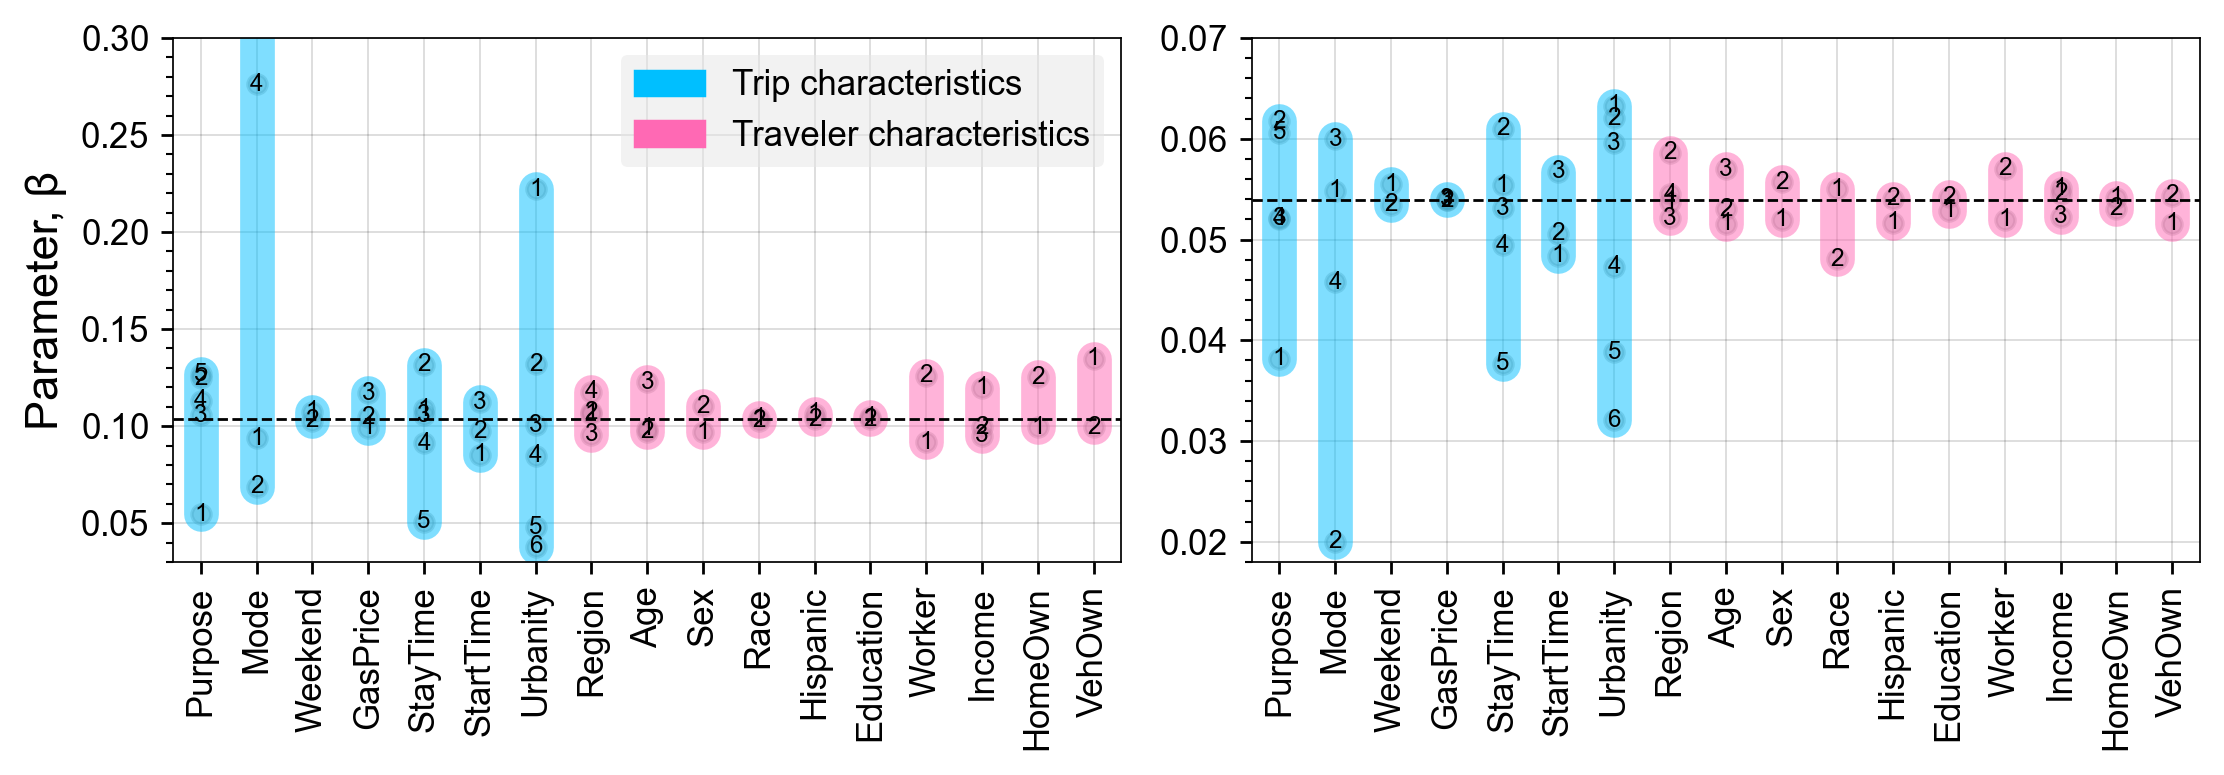

In [13]:
def fig_compare_betas(fitted=fitted, hists=var_hist, grps=col_groups,
                      levels=levels, trips=trips, size=(9, 3.2), dpi=150):
    fit = fitted.query('func=="Base exponential"').explode('params')
    hists = hists.merge(grps, on='factor')
    fit = fit.merge(grps, on='factor').rename(columns=D(params='beta'))
    fit = fit.merge(levels, on=('factor', 'level'))
    fit.factor = ordered_factor(fit.factor)
    fit['x'], fit['y'] = fit.factor.cat.codes, -fit.beta
    _, axes = plt.subplots(1, 2, figsize=size, dpi=dpi)
    betas = []
    for j, target, vmax, ymin, ymax in [
            (0, 'Distance', 80, 0.03, 0.3),
            (1, 'Time', 90, 0.018, 0.07)]:
        Y, X = np.histogram(trips[target].clip(0, vmax), bins=np.arange(0, vmax + 1))
        Y = (1 - (Y / Y.sum()).cumsum()).clip(0)
        beta = -curve_fit(lambda x, b: np.exp(b * x), X[1:], Y)[0][0]
        df = hists.query(f'target=="{target}"')
        df = df.merge(fit[['target', 'factor', 'level', 'beta']])
        df = df.sort_values('beta').reset_index(drop=1)
        betas.append(df)
        ax = pplot(axes[j], xminor=0, xlim=(-0.5, fit.x.max() + 0.5),
                   ylim=(ymin, ymax), ylab='Parameter, β' if j == 0 else '')
        df1 = fit.query(f'target=="{target}"')
        for (_, color), df in df1.groupby(['factor', 'color']):
            x = df.x.iloc[0]
            ax.scatter(df.x, df.y, s=30, alpha=0.3, color='grey')
            ax.plot([x, x], [df.y.min(), df.y.max()], lw=10,
                color=color, alpha=0.5, solid_capstyle='round')
            for _, r in df.iterrows():
                if r.y > ymax: continue
                ax.text(x, r.y, str(r.level_num), fontsize=7, ha='center', va='center')
        ax.axhline(beta, ls='--', color='k', lw=0.8)
        ax.set_xticks(fit.x.unique(), fit.factor.cat.categories, rotation=90)
        if j == 0:
            ax.legend(fontsize=10, handles=[
                mpl.patches.Patch(label=k + ' characteristics', color=v) for k, v in
                grps.groupby(['group', 'color'], sort=False).size().index])
    plt.subplots_adjust(wspace=0.1)
    plt.tight_layout()
    imsave('Impedance decay rate parameter comparison by factor')
    return pd.concat(betas)

betas = fig_compare_betas(dpi=250).disp()

## 4.4. Variation by state

In [14]:
# df = (betas.query('factor=="State"').assign(Area=lambda df: -1/df.beta)
#       .pivot_table('Area', 'level', 'target').astype(float)
#       .rename_axis('code').reset_index()).disp()

In [15]:
# states = (gpd.read_parquet('../../access/data/zones/us/state_2020.parquet')
#           .merge(pd.read_csv('../../access/data/zones/state_codes.csv'), on='name')
#           .merge(df, on='code')[['name', 'code', 'Distance', 'Time', 'geometry']]
#           .to_crs(CRS_M).assign(num=lambda df: df.index + 1)).disp()

In [16]:
# _, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=150)
# for i, col in enumerate(['Distance', 'Time']):
#     ax = pplot(axes[i], axoff=1, title=col)
#     states.plot(col, ax=ax, ec='grey', lw=0.2, cmap='rainbow', legend=True,
#                 legend_kwds=D(shrink=0.5, label='Area under curve (Trip length)'))
# imsave('Impedance beta by US state')

In [17]:
# ax = pplot(size=(16, 4), dpi=150, xminor=0)
# sns.barplot(df.groupby, ax=ax, x='level', y='beta', hue='target', palette=['c', 'orange']);

# 5. SHAP analysis

## 5.1. Dataset for modeling

In [18]:
X = pd.get_dummies(trips[factors]).disp(0)

747,088 rows x 52 cols; Memory: 37.0 MiB


,Purpose_HBW,Purpose_HBSHOP,Purpose_HBSOC,Purpose_HBO,Purpose_NHB,Mode_Drive,Mode_Transit,Mode_Walk,Mode_Bike,Weekend_Yes,...,Education_College,Worker_Yes,Worker_No,Income_Low,Income_Mid,Income_High,HomeOwn_Own,HomeOwn_Rent,VehOwn_Low,VehOwn_High
,<bool>,<bool>,<bool>,<bool>,<bool>,<bool>,<bool>,<bool>,<bool>,<bool>,...,<bool>,<bool>,<bool>,<bool>,<bool>,<bool>,<bool>,<bool>,<bool>,<bool>


In [19]:
Y = pd.concat([np.log(1 + trips[x]).rename(x) for x in ['Distance', 'Time']], axis=1)

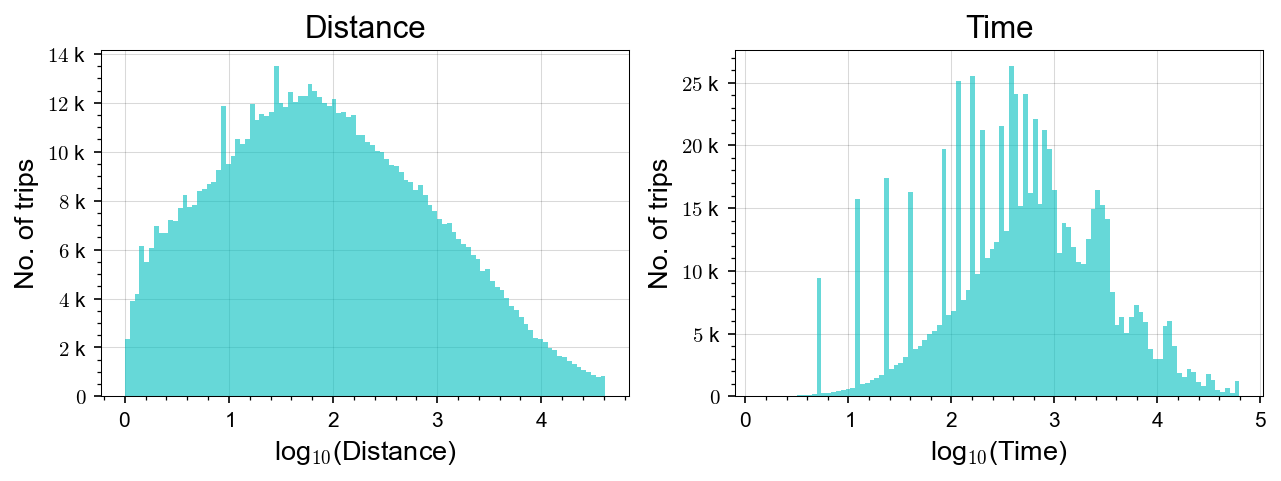

In [20]:
_, axes = plt.subplots(1, 2, figsize=(10, 3))
for ax, trg in zip(axes, Y.columns):
    ax = pplot(ax, title=trg, xlab='log$_{10}$(%s)' % trg,
               yeng=1, ylab='No. of trips')
    Y[trg].hist(bins=100, ax=ax, color='c', alpha=0.6)

In [21]:
train_ratio, val_ratio = 0.7, 0.15
np.random.seed(SEED)
np.random.shuffle(X.index.values)
splits = np.split(X.index, [int(x * len(X)) for x in [
    train_ratio, train_ratio + val_ratio, 1]])
idx = D(zip(['train', 'val', 'test'], splits[:-1]))
for k, v in idx.items():
    print(f'{k.upper()}: {len(v):,}')

TRAIN: 522,961
VAL: 112,063
TEST: 112,064


## 5.2. Test models

In [22]:
test_models = (
    ## Linear models
    ('Linear Regression', LinearRegression(), D(
        fit_intercept=[True, False],
    )),
    ('Bayesian Ridge', BayesianRidge(max_iter=1000), D(
        alpha_1=[.5e-6, 1e-6, 2e-6],
        alpha_2=[.5e-6, 1e-6, 2e-6],
        lambda_1=[.5e-6, 1e-6, 2e-6],
        lambda_2=[.5e-6, 1e-6, 2e-6],
    )),
    ('SGD Regression', SGDRegressor(max_iter=1000), D(
        alpha=[1e-05, 0.0001, 0.001, 0.01],
        l1_ratio=[0.1, 0.15, 0.2, 0.3],
        penalty=['l2', 'elasticnet'],
    )),
    ('Linear SVR', LinearSVR(dual='auto', max_iter=50_000), D(
        C=[0.5, 0.75, 1.0, 1.25, 1.5],
        epsilon=[0, 0.1, 0.2],
        loss=['epsilon_insensitive', 'squared_epsilon_insensitive']
    )),
    ## Decision tree models
    ('Random Forest', RandomForestRegressor(n_jobs=4), D(
       n_estimators=[100, 200, 500, 750],
       max_depth=[10, 20, 30, 40],
    )),
    ('Light Gradient Boost', LGBMRegressor(
        n_jobs=4, force_row_wise=True, num_leaves=1000, verbosity=-1), D(
            learning_rate=[0.05, 0.1, 0.5],
            max_depth=[10, 20, 30, 40],
            n_estimators=[100, 200, 500, 750],
    )),
    ('Extreme Gradient Boost', XGBRegressor(n_jobs=4, verbosity=0), D(
        booster=['gbtree', 'gblinear'],
        learning_rate=[0.05, 0.1, 0.5],
        n_estimators=[100, 200, 500, 750],
    )),
)

## 5.3. Cross validate for hyperparameter tuning

In [23]:
metrics = D(r2=r2_score, mae=mean_absolute_error, 
            mape=mean_absolute_percentage_error, mse=mean_squared_error)

In [24]:
def cross_validate(X=X, Y=Y, idx=idx, models=test_models,
                   metrics=metrics, njobs=1, overwrite=False):
    outpath = DATA / 'impedance/model_cv.pkl'
    if outpath.exists() and not overwrite:
        return pd.read_pickle(outpath)
    res = []
    for target in Y.columns:
        Xval, yval = X.loc[idx['val']], Y.loc[idx['val'], target]
        Xtest, ytest = X.loc[idx['test']], Y.loc[idx['test'], target]
        pbar = tqdm(models)
        for name, model, params in pbar:
            pbar.set_description(name)
            cv = GridSearchCV(model, params, cv=2, n_jobs=njobs, scoring='r2')
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                cv.fit(Xval, yval)
            row = D(target=target, model=name, params=cv.best_params_,
                    estimator=cv.best_estimator_)
            ypred = cv.best_estimator_.predict(Xtest)
            for metric, func in metrics.items():
                row[metric] = func(ytest, ypred)
            res.append(row)
    res = Pdf(res)
    res.to_pickle(mkfile(outpath))
    return res

cv = cross_validate(njobs=12, overwrite=0).disp() # 11m12s

14 rows x 8 cols; Memory: 0.0 MiB


,target,model,params,estimator,r2,mae,mape,mse
,<object>,<object>,<object>,<object>,<float64>,<float64>,<float64>,<float64>
0,Distance,Linear Regression,{'fit_intercept': False},LinearRegression(fit_intercept=False),0.343806,0.658501,0.89979,0.681571


### 5.3.1. Compare model fitness

In [25]:
(cv.drop(columns=['params', 'estimator'])
 .assign(model=lambda df: ordered_factor(df.model))
 .melt(['target', 'model'], var_name='metric')
 .pivot_table('value', 'model', ['target', 'metric']))

target                  Distance                                    Time  \
metric                       mae      mape       mse        r2       mae   
model                                                                      
Linear Regression       0.658501  0.899790  0.681571  0.343806  0.564024   
Bayesian Ridge          0.658479  0.899785  0.681572  0.343806  0.564024   
SGD Regression          0.660349  0.915959  0.682426  0.342983  0.564584   
Linear SVR              0.658469  0.899467  0.681571  0.343807  0.564015   
Random Forest           0.650633  0.868155  0.671368  0.353629  0.555423   
Light Gradient Boost    0.644021  0.859328  0.660372  0.364216  0.552362   
Extreme Gradient Boost  0.643492  0.862667  0.659024  0.365514  0.552227   

target                                                
metric                      mape       mse        r2  
model                                                 
Linear Regression       0.270498  0.513964  0.143653  
Bayesian Ridge          0.270561  0.513970  0.143644  
SGD Regression          0.269639  0.514491  0.142776  
Linear SVR              0.270538  0.513960  0.143661  
Random Forest           0.266155  0.499911  0.167068  
Light Gradient Boost    0.264467  0.495301  0.174749  
Extreme Gradient Boost  0.264630  0.494310  0.176400

## 5.4. Compute SHAP values

In [26]:
def get_shaps(cv=cv, model='Extreme Gradient Boost',
              X=X, seed=SEED, overwrite=False):
    outpath = DATA / 'impedance/shaps.parquet'
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    res = []
    for target in tqdm(['Distance', 'Time']):
        row = cv.query(f'model=="{model}" & target=="{target}"').iloc[0]
        explainer = shap.TreeExplainer(row.estimator, seed=seed)
        shaps = explainer(X).values
        df = Pdf(shaps, columns=X.columns).astype(np.float32)
        df.insert(0, 'Target', target)
        res.append(df)
    df = pd.concat(res).astype(D(Target=CAT))
    df.to_parquet(mkfile(outpath))
    return df

shaps = get_shaps(overwrite=0).disp() # 19m28s

1,494,176 rows x 53 cols; Memory: 309.2 MiB


,Target,Purpose_HBW,Purpose_HBSHOP,Purpose_HBSOC,Purpose_HBO,Purpose_NHB,Mode_Drive,Mode_Transit,Mode_Walk,Mode_Bike,...,Education_College,Worker_Yes,Worker_No,Income_Low,Income_Mid,Income_High,HomeOwn_Own,HomeOwn_Rent,VehOwn_Low,VehOwn_High
,<category>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,...,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>
0,Distance,-0.060222,0.008904,-0.011895,0.022393,0.040871,0.005986,-0.004872,0.109285,0.003776,...,0.0,-0.019401,0.0,0.025941,0.00048,-0.016371,0.010399,0.0,0.001747,0.0


### 5.4.1. Plot variable contributions

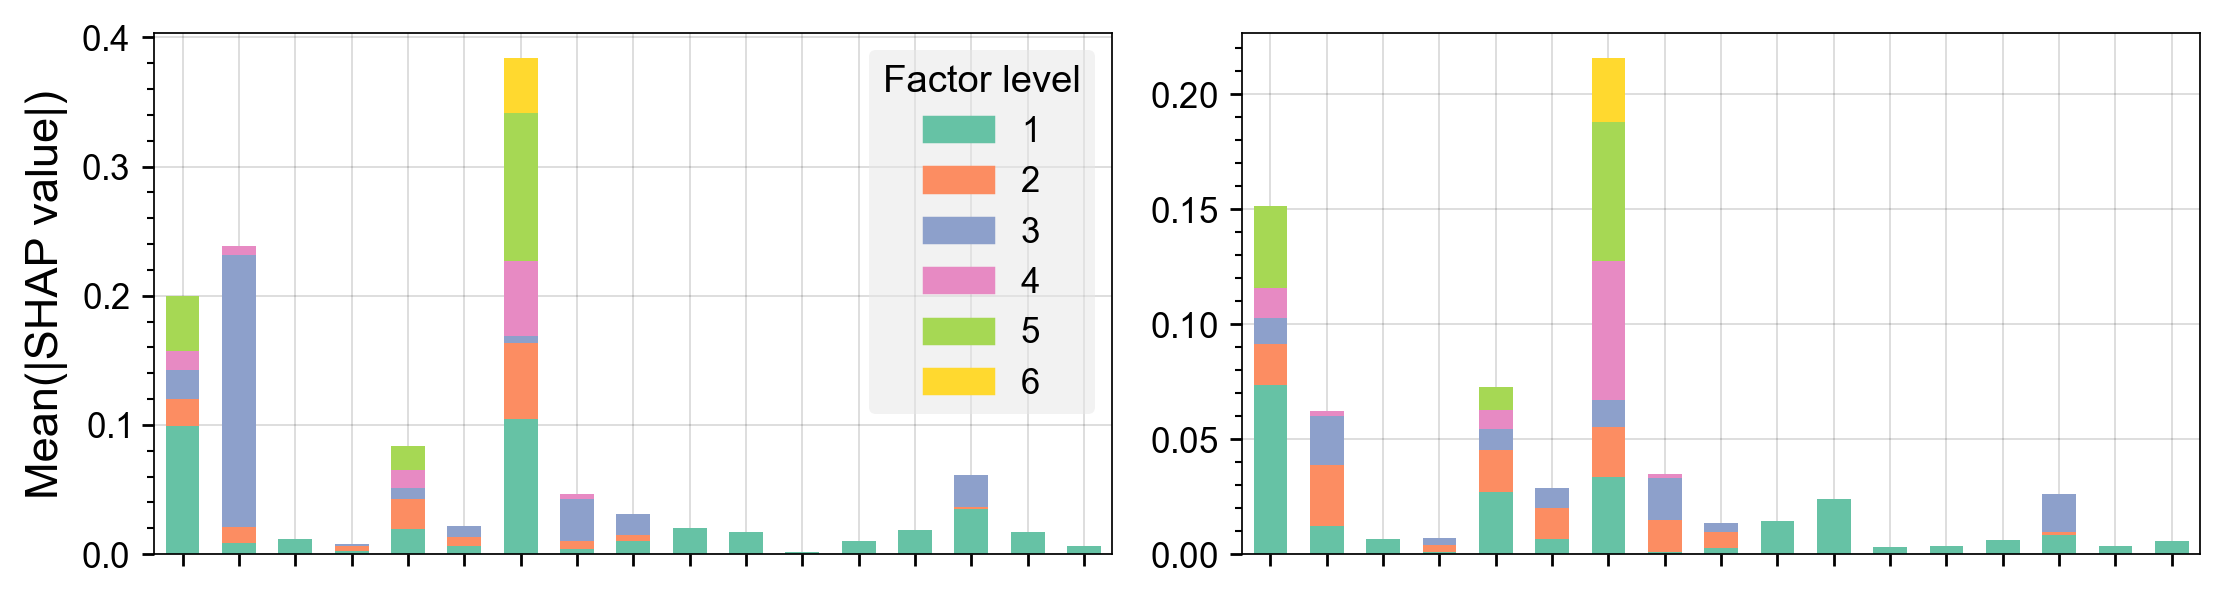

In [27]:
def fig_shap_contrib(shaps=shaps, dpi=150, cmap='Set2'):
    sh = np.abs(shaps.set_index('Target'))
    sh = sh.groupby('Target').mean(0).reset_index().melt('Target')
    sh['Factor'], sh['Level'] = [ordered_factor(x) for x in 
                                 zip(*sh.variable.str.split('_'))]
    _, axes = plt.subplots(1, 2, figsize=(9, 2.5), dpi=dpi)
    for i, target in enumerate(['Distance', 'Time']):
        ax = pplot(axes[i], xminor=0, xlim=(-0.5, sh.Factor.nunique() - 0.5),
                   ylab='Mean(|SHAP value|)' if i == 0 else '')
        for col, d in sh[sh.Target == target].groupby('Factor'):
            bottom = d.value.cumsum().shift().fillna(0)
            colors = sns.color_palette(cmap, len(d)).as_hex()
            for val, bottom, color in zip(d.value, bottom, colors):
                ax.bar(col, val, bottom=bottom, color=color, width=0.6)
        ax.set_xticklabels([])
        if i == 0:
            max_levels = sh.groupby(['Target', 'Factor']).size().max()
            colors = sns.color_palette(cmap, max_levels)
            ax.legend(title='Factor level', title_fontsize=11,
                      fontsize=10, handles=[
                mpl.patches.Patch(color=c, label=f'{i+1}')
                for i, c in enumerate(colors)])
    plt.tight_layout()
    imsave('Impedance feature contributions SHAP')

fig_shap_contrib(dpi=250) # 3s

# 6. SES factors

In [28]:
trips['SES'] = 'Mid'
trips.loc[trips.pipe(lambda df: (
    + (df.Age == 'Senior').astype(int)
    + (df.Worker == 'No').astype(int)
    + (df.Race == 'Non-White').astype(int)
    + (df.Income == 'Low').astype(int)
    + (df.HomeOwn == 'Rent').astype(int)
    + (df.VehOwn == 'Low').astype(int)
) >= 5), 'SES'] = 'Low'
trips.loc[trips.pipe(lambda df: (
    + (df.Age.isin(['Young', 'Mid'])).astype(int)
    + (df.Worker == 'Yes').astype(int)
    + (df.Race == 'White').astype(int)
    + (df.Income.isin(['Mid', 'High'])).astype(int)
    + (df.HomeOwn == 'Own').astype(int)
    + (df.VehOwn.isin(['Mid', 'High'])).astype(int)
) >= 5), 'SES'] = 'High'
trips.SES = pd.Categorical(trips.SES, categories=['Low', 'Mid', 'High'])
trips.SES.value_counts()

SES
High    398603
Mid     333528
Low      14957
Name: count, dtype: int64

In [29]:
# fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=150, sharey=True)
# for i, target, vmax in [(0, 'Distance', 100), (1, 'Time', 90), (2, 'Speed', 80)]:
#     ax = pplot(axes[i], xlab=target, ylab='Probability, $P(X≥x)$' if i == 0 else '')
#     for lab, color in [('Low', 'r'), ('High', 'b')]:
#         y = trips.query(f'SES=="{lab}"')[target].clip(0, vmax)
#         y, x = np.histogram(y, bins=np.arange(0, vmax+1))
#         ax.plot(x[1:], (y / y.sum()).cumsum(), label=lab, color=color)
#     ax.legend()
# plt.tight_layout()

# 7. Finalize factors

In [30]:
trips2 = trips.copy()
# trips2['LongStay'] = ordered_factor((trips.StayTime == 'Very long')
#                                     .map({True: 'Yes', False: 'No'}))
# trips2['Purpose'] = trips2.Purpose.map(D(
#         HBW='Work', HBSHOP='Shopping', HBSOC='Other', HBO='Other'))
# trips2 = trips2.query('ODUrban != "R ↔ U"').dropna().reset_index(drop=1)
# trips2.ODUrban = trips2.ODUrban.cat.remove_unused_categories()
trips2['Purpose'] = (trips2.Purpose == 'HBW').map({True: 'Work', False: 'Non-work'})
trips2.Purpose = pd.Categorical(trips2.Purpose, categories=['Work', 'Non-work'])
trips2 = trips2[['Distance', 'Time', 'Speed', 'Mode', 'Purpose', 'Urbanity', 'SES']].disp()
trips2.to_parquet(DATA / 'impedance/trips2.parquet')

747,088 rows x 7 cols; Memory: 20.0 MiB


,Distance,Time,Speed,Mode,Purpose,Urbanity,SES
,<float64>,<float64>,<float64>,<category>,<category>,<category>,<category>
0,8.439379,16.182075,31.291583,Drive,Non-work,S → S,Mid


### 7.1.1. Distributions of finalized variables

  0%|          | 0/3 [00:00<?, ?it/s]

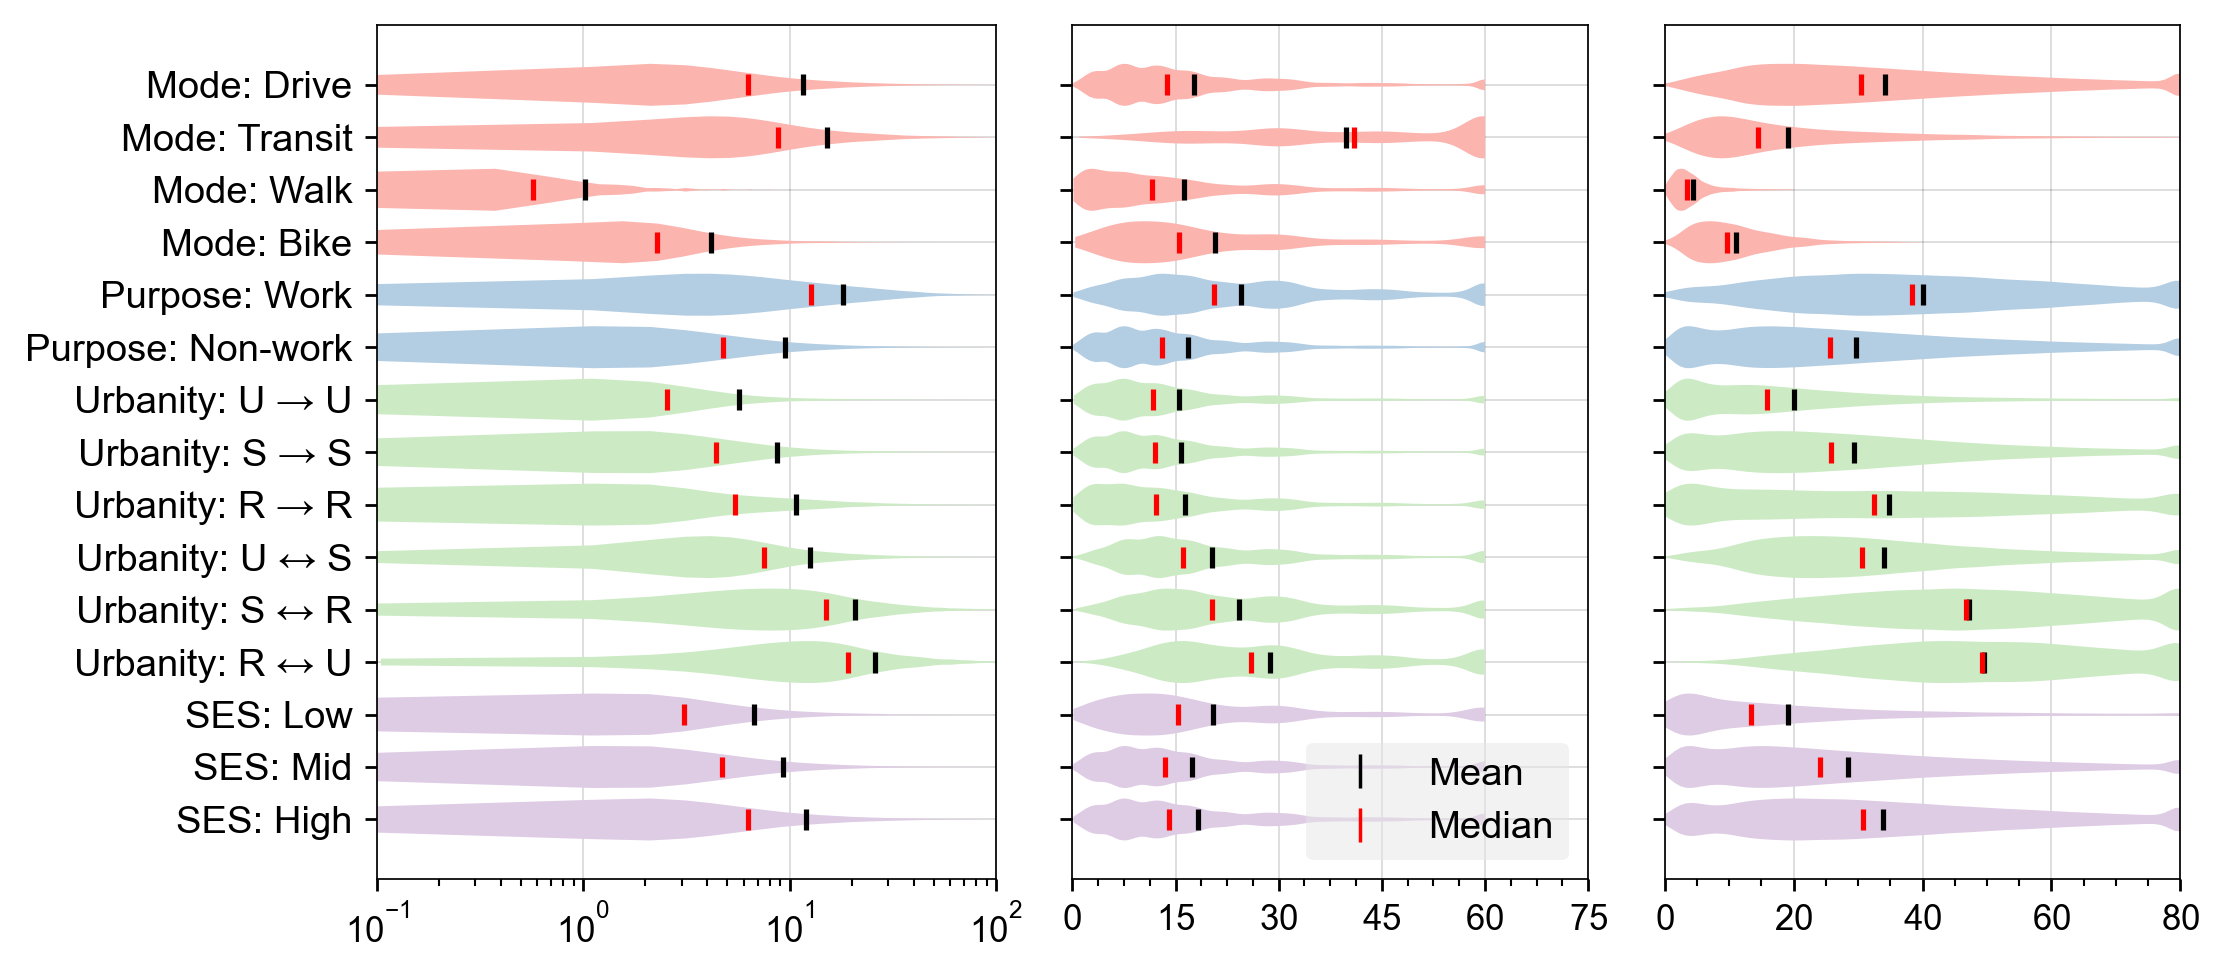

In [31]:
def fig_final_vars_distr(trips=trips2, dpi=150, cmap='Pastel1'):
    _, axes = plt.subplots(1, 3, figsize=(9, 4), dpi=dpi,
                           gridspec_kw=D(width_ratios=[1.2, 1, 1]))
    ticker = mpl.ticker.EngFormatter(places=1)
    factors = list(trips.select_dtypes(CAT).columns)
    colors = D(zip(factors, sns.color_palette(cmap, len(factors)).as_hex()))
    for j, (var, rng) in enumerate(tqdm([('Distance', (0.1, 100)),
                                         ('Time', (0, 60)),
                                         ('Speed', (0, 80))])):
        df = Pdf(sum([[D(col=col, cat=x[0], label=col + ': ' + x[0],
                         vals=x[1].values, n=ticker(len(x[1])))
                       for x in trips.groupby(col)[var]]
                      for col in factors], []))
        df.vals = [x.clip(*rng) for x in df.vals]
        df['color'] = df.col.map(colors)
        ax = pplot(axes[j], xlog=var == 'Distance', yminor=0, xlim=rng)
        x = ax.violinplot(list(df.vals), positions=np.arange(len(df)),
                          vert=False, widths=0.8,
                          showextrema=False, showmeans=True, showmedians=True)
        for line, color in zip(x['bodies'], df.color):
            line.set_alpha(1)
            line.set_facecolor(color)
            line.set_linewidth(0)
        x['cmeans'].set_edgecolor('k')
        x['cmedians'].set_edgecolor('r')
        ax.invert_yaxis()
        ax.set_yticks(np.arange(len(df)), df.label, fontsize=11)
        if var == 'Time': ax.set_xticks(np.arange(0, 75+1, 15))
        if j != 0: ax.set_yticklabels([])
        if j == 1:
            ax.legend(loc='lower right', handles=[
                mpl.lines.Line2D([0], [0], label=k, color=v,
                                 marker='|', markersize=10, lw=0)
                for k, v in [('Mean', 'k'), ('Median', 'r')]])
    plt.tight_layout()
    imsave('Distributions of finalized variables')

fig_final_vars_distr(dpi=250, cmap='Pastel1') # 30s

## 7.2. Correlation

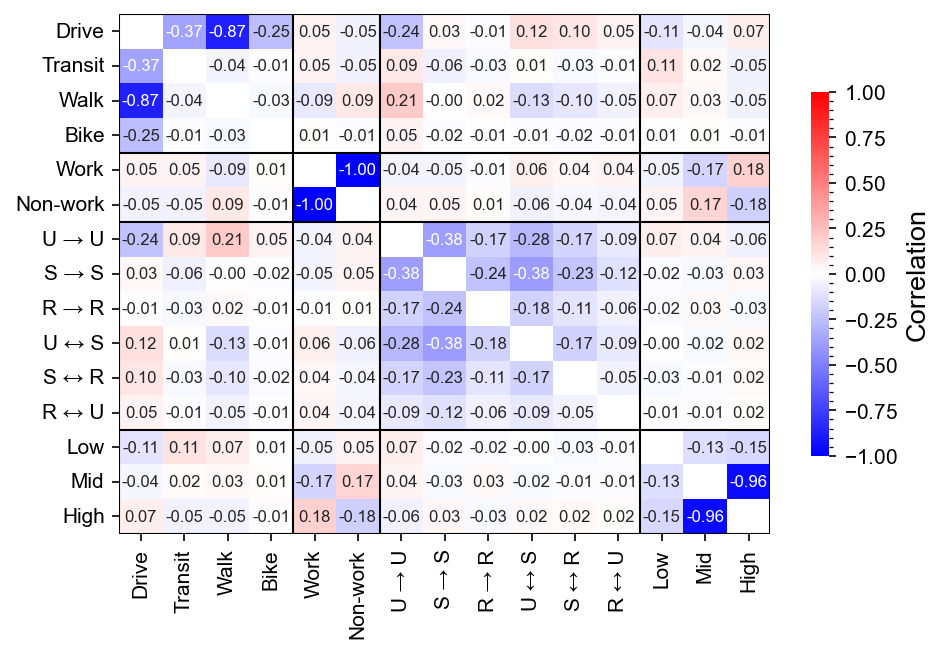

In [32]:
def plot_corr_final_vars(trips=trips2, size=(7, 4.5), dpi=150, cmap='bwr'):
    X = pd.get_dummies(trips.select_dtypes(CAT), prefix_sep='__')
    corr = X.corr()
    np.fill_diagonal(corr.values, np.nan)
    ax = pplot(size=size, dpi=dpi, xminor=0, yminor=0, gridcolor='#ffff')
    labels = [x.split('__')[1] for x in X.columns]
    ax = sns.heatmap(corr, ax=ax, cmap=cmap, vmin=-1, vmax=1,
                     xticklabels=labels, yticklabels=labels,
                     cbar=True, cbar_kws=D(shrink=0.7, label='Correlation'),
                     annot=True, fmt='.2f', annot_kws=D(fontsize=8))
    cols = Pdf(D(col=X.columns))
    cols['feat'] = cols.col.str.split('__').str[0]
    cols['idx'] = (cols.feat.astype(CAT).cat.codes.diff() != 0)
    for x in list(cols.idx[cols.idx].index) + [len(cols)]:
        ax.axvline(x, color='k', lw=1)
        ax.axhline(x, color='k', lw=1)

x = plot_corr_final_vars(dpi=150); x

## 7.3. Parameters

In [33]:
var_hist2 = pd.concat([
    get_var_hist(trips2[['Distance', 'Time']]
                 .assign(X='Overall').astype(D(X=CAT))),
    get_var_hist(trips2)]).disp()

32 rows x 5 cols; Memory: 0.0 MiB


,target,factor,level,x,y
,<object>,<object>,<object>,<object>,<object>
0,Distance,X,Overall,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.8736239907480778, 0.7626384040434326, 0.669..."


In [34]:
fitted2 = fit_decay_functions({k: v for k, v in imped_funcs.items() if k in [
    'Base exponential', 'Power exponential', 'Tanner']}, hists=var_hist2).disp()

96 rows x 6 cols; Memory: 0.0 MiB


,target,factor,level,func,r2,params
,<object>,<object>,<object>,<object>,<float64>,<object>
0,Distance,X,Overall,Base exponential,0.972257,[-0.10377313732146541]


In [35]:
df = (fitted2.assign(factor=lambda df: ordered_factor(df.factor),
                     level=lambda df: ordered_factor(df.level)))
df['coef'] = [[f'β{i+1}' for i in range(len(x))] for x in df.params]
df = df.explode(['coef', 'params'])
df.loc[(df.func=='Base exponential') & (df.coef=='β1'), 'params'] *= -1
df.loc[(df.func=='Tanner') & (df.coef=='β2'), 'params'] *= -1
df.pivot_table('params', ['factor', 'level'], ['func', 'target', 'coef'])

func              Base exponential           Power exponential            \
target                    Distance      Time          Distance             
coef                            β1        β1                β1        β2   
factor   level                                                             
X        Overall          0.103773  0.053918          0.186364  0.764821   
Mode     Drive            0.093689  0.054819          0.146403  0.826583   
         Transit          0.068864  0.019987          0.095342  0.887126   
         Walk             1.079607  0.059946          1.173653  0.749212   
         Bike             0.276204  0.045774          0.332796   0.87111   
Purpose  Work             0.054606  0.038162          0.051442  1.019025   
         Non-work         0.120068  0.057694          0.209672  0.760833   
Urbanity U → U            0.222133  0.063251           0.37436  0.692484   
         S → S            0.131766  0.062023          0.222266  0.765208   
         R → R            0.100489  0.059547          0.201488  0.729209   
         U ↔ S            0.084798  0.047322          0.093808  0.961689   
         S ↔ R            0.047993  0.038794          0.029596  1.150505   
         R ↔ U             0.03794  0.032076          0.015334  1.264268   
SES      Low              0.176889  0.046369          0.317203  0.702582   
         Mid              0.121397  0.055596          0.211232  0.761751   
         High             0.090436  0.052876            0.1595  0.784504   

func                                     Tanner                                
target                 Time            Distance                Time            
coef                     β1        β2        β1        β2        β1        β2  
factor   level                                                                 
X        Overall   0.022688  1.282219 -0.238125  0.055684  0.148926   0.07652  
Mode     Drive     0.019468  1.339882 -0.172748  0.060225  0.173984  0.081583  
         Transit   0.001333  1.678955 -0.089041  0.054163  0.136678  0.030993  
         Walk      0.058199  1.009813   0.59639  1.164806  0.005196  0.060751  
         Bike      0.023316  1.209078 -0.403949  0.155462  0.114108  0.061485  
Purpose  Work      0.008365  1.443685  0.008493   0.05583  0.158714  0.057253  
         Non-work  0.023668  1.297793 -0.273764  0.060377  0.162788  0.083553  
Urbanity U → U     0.033462  1.220136 -0.521275  0.072442  0.139789  0.086805  
         S → S     0.027285  1.280976 -0.297426  0.063833  0.162757  0.088984  
         R → R      0.03841  1.146435 -0.239819  0.053442  0.086193  0.073168  
         U ↔ S     0.010375   1.47905 -0.045405  0.076161  0.207321  0.076801  
         S ↔ R     0.005855  1.559027  0.081407  0.059271  0.193568  0.062617  
         R ↔ U     0.002706  1.695537  0.115003  0.051825  0.199083  0.053747  
SES      Low       0.025234  1.188989 -0.392749  0.074161  0.102608  0.060525  
         Mid        0.02256  1.297718  -0.27217  0.061778  0.158783  0.080248  
         High      0.022457  1.276877 -0.196635  0.053476  0.144064  0.074404